In [63]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff

## 1-Download dataset

In [114]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [65]:
df_train = data.sample(20000)

In [66]:
#Basics statistics
print("Number of rows : {}".format(df_train.shape[0]))
print()

print("Display of dataset: ")
display(df_train.head())
print()

print("Basics statistics: ")
data_desc = df_train.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df_train.isnull().sum()/df_train.shape[0])

Number of rows : 20000

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
136022,US,41,1,Seo,7,0
44548,China,29,0,Ads,1,0
131974,US,26,1,Seo,4,0
153211,US,36,1,Seo,3,0
12976,UK,29,1,Ads,7,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,20000,20000.000000,20000.00000,20000,20000.000000,20000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,11384,NaN,NaN,9864,NaN,NaN
mean,NaN,30.462200,0.68190,NaN,4.894600,0.033800
std,NaN,8.205171,0.46575,NaN,3.339184,0.180719
min,NaN,17.000000,0.00000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.00000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.00000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.00000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

## 2- EDA

d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

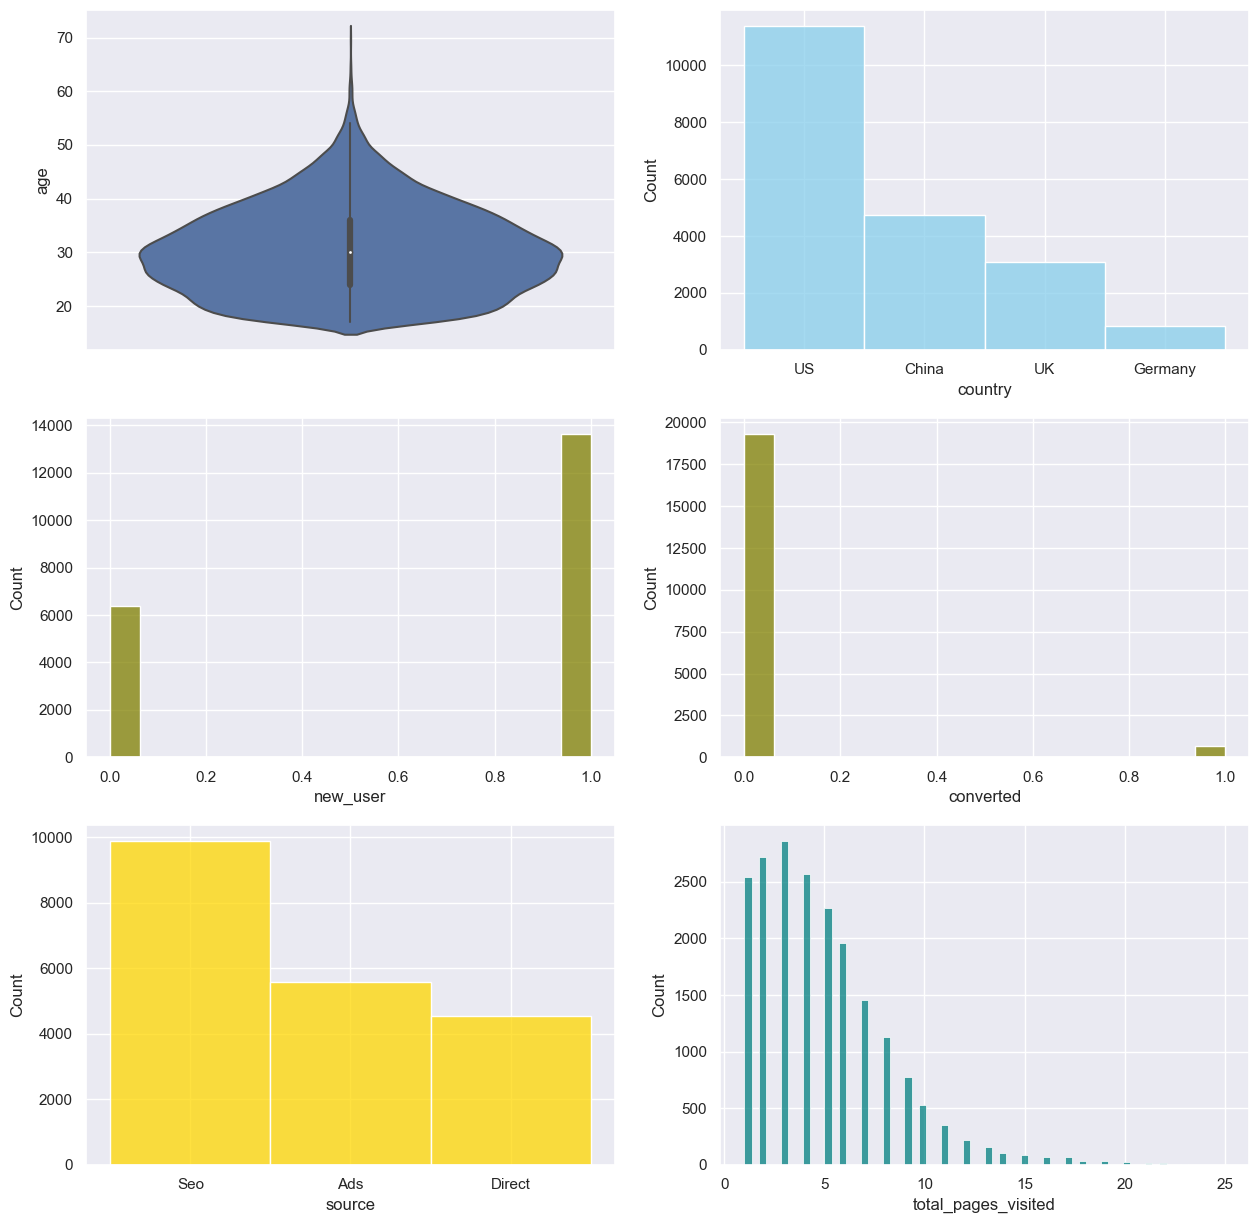

In [70]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.violinplot(y=df_train["age"], ax=axs[0, 0])
sns.histplot(data=df_train, x="country", color="skyblue", ax=axs[0, 1])
sns.histplot(data=df_train, x="new_user", color="olive", ax=axs[1, 0])
sns.histplot(data=df_train, x="converted", color="olive", ax=axs[1, 1])
sns.histplot(data=df_train, x="source",  color="gold", ax=axs[2, 0])
sns.histplot(data=df_train, x="total_pages_visited", color="teal", ax=axs[2, 1])

plt.show()

<Axes: >

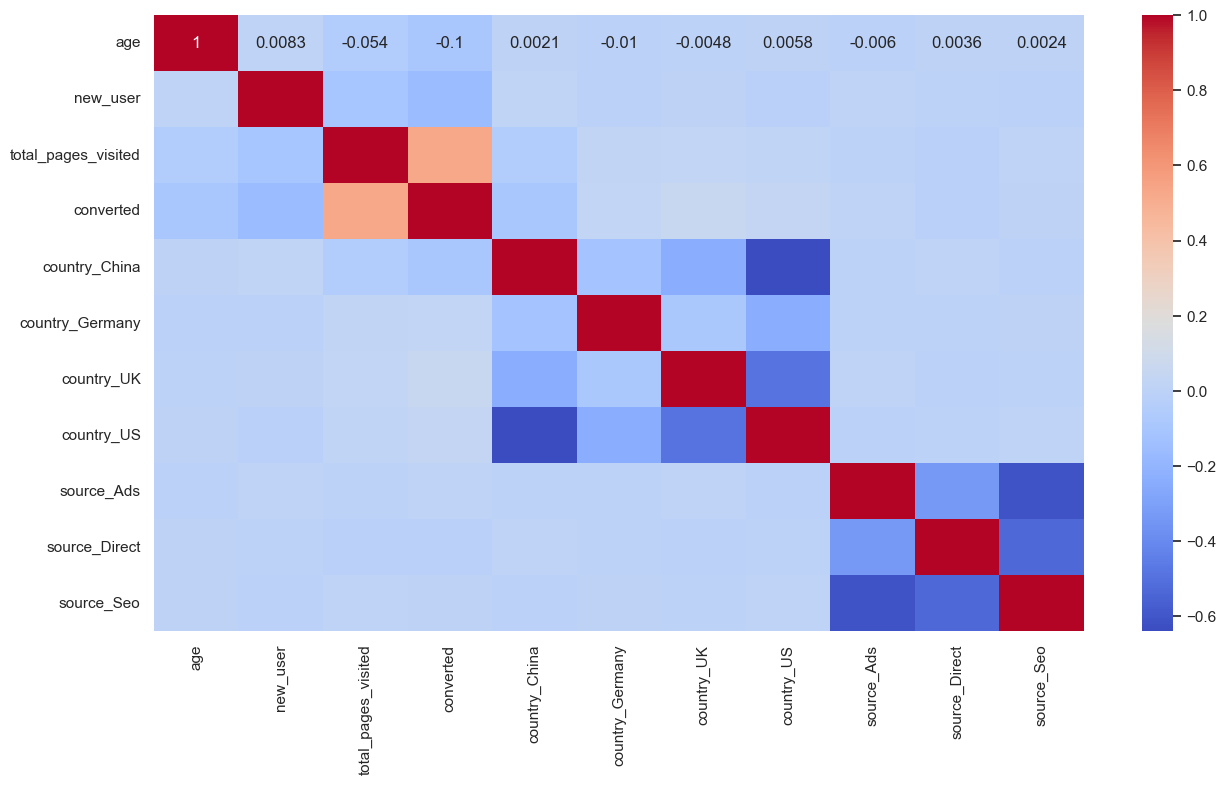

In [71]:
df_encoded = pd.get_dummies(df_train, columns=['country', 'source'])
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

## 3-Preprocessing

In [72]:
# Separate target variable Y from features X
target_name = 'converted'

#print("Separating labels from features...")
Y = df_train.loc[:,target_name]
X = df_train.drop(target_name, axis = 1)
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

...Done.
136022    0
44548     0
131974    0
153211    0
12976     0
Name: converted, dtype: int64

       country  age  new_user source  total_pages_visited
136022      US   41         1    Seo                    7
44548    China   29         0    Ads                    1
131974      US   26         1    Seo                    4
153211      US   36         1    Seo                    3
12976       UK   29         1    Ads                    7



In [73]:
#Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


In [74]:
#Train test split
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify= Y)
print("...Done.")

Dividing into train and test sets...
...Done.


In [75]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [76]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

# Encode target variable Y
labelencoder = LabelEncoder()

print("Encoding labels on train set...")
print(Y_train.head())
print()
Y_train = labelencoder.fit_transform(Y_train)
print("...Done.")
print(Y_train[0:5])
print()

print("Encoding labels on test set...")
print(Y_test.head())
print()
Y_test = labelencoder.transform(Y_test)
print("...Done.")
print(Y_test[0:5])
print()

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
198462      UK   34         1     Seo                    8
184332   China   54         1     Seo                    5
64245       US   47         1     Seo                    8
158110   China   19         1  Direct                    1
159679      US   32         1     Ads                    9
...Done.
[[ 0.43002329  0.67936031  0.92412545  0.          1.          0.
   0.          1.        ]
 [ 2.85977852  0.67936031  0.02807621  0.          0.          0.
   0.          1.        ]
 [ 2.00936419  0.67936031  0.92412545  0.          0.          1.
   0.          1.        ]
 [-1.39229314  0.67936031 -1.16665611  0.          0.          0.
   1.          0.        ]
 [ 0.18704776  0.67936031  1.22280853  0.          0.          1.
   0.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
217204      US   40         

## 4-Model Training

### 4.1- Logistic Regression

4.1.1- Model

In [77]:
# Train model
model = LogisticRegression()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...
...Done.


4.1.2- Performance assesment

In [78]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()


Predictions on training set...
...Done.
[0 0 0 ... 0 0 1]

Probabilities on training set...
...Done.
[[9.93120239e-01 6.87976110e-03]
 [9.99989838e-01 1.01619598e-05]
 [9.98237776e-01 1.76222401e-03]
 ...
 [9.99611085e-01 3.88914948e-04]
 [9.99995658e-01 4.34150226e-06]
 [2.75185787e-01 7.24814213e-01]]



In [79]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()


Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.28673745e-01 7.13262553e-02]
 [9.99898796e-01 1.01203891e-04]
 [7.76353014e-01 2.23646986e-01]
 ...
 [9.99977120e-01 2.28801984e-05]
 [9.99988672e-01 1.13284434e-05]
 [9.84013522e-01 1.59864779e-02]]



In [80]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()


accuracy on training set :  0.9859285714285714
accuracy on test set :  0.987

f1-score on training set :  0.7685076380728554
f1-score on test set :  0.7914438502673796



4.1.3- Confusion matrix and ROC Curve

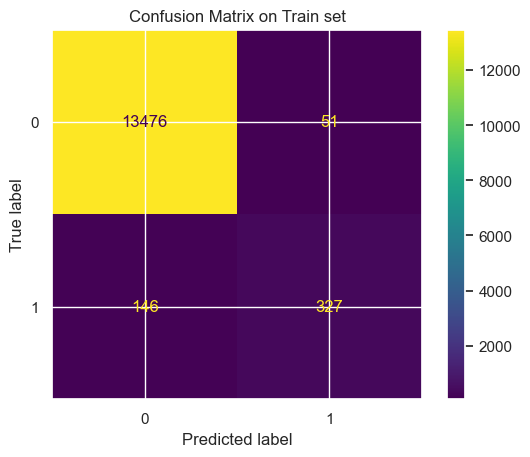

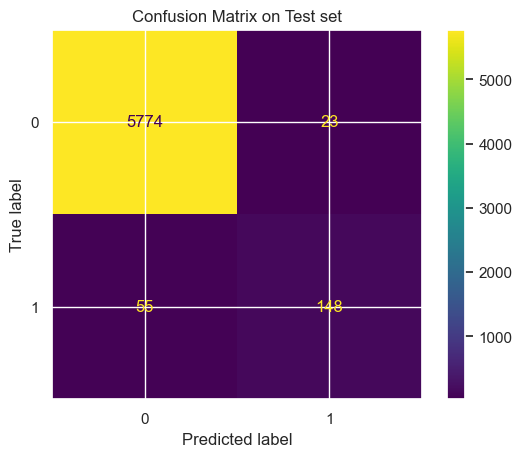

In [81]:
# Visualize confusion matrices
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=ax)
plt.show()

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=ax)
plt.show()



Le modèle de base a un f1-score de 77%. Nous allons tester d'autres modèles et voir si le f1-score s'améliore.

4.1.4-Gridsearch

In [82]:
# Instantiating logistic regression classifier
logreg = LogisticRegression(max_iter=1000)

In [83]:
# Creating the hyperparameter grid
param_grid = {
    'penalty': ['l2', None],
    'C': [0.1, 1, 10, 100]
}

# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)

logreg_cv.fit(X_train, Y_train)

logreg_best= logreg_cv.best_estimator_
best_f1_score_logreg= logreg_cv.best_score_

Y_pred= logreg_best.predict(X_test)
test_f1_score_logreg= f1_score(Y_test, Y_pred)
 
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages

Tuned Logistic Regression Parameters: {'C': 0.1, 'penalty': None}
Best score is 0.986


d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


4.1.5- Boosting

In [84]:
#AdaBoost
model = AdaBoostClassifier(logreg)

params= {
    'estimator__C': [0.1, 1, 5, 10, 20],
    'n_estimators': [5, 10, 20, 30]
}

gridsearch= GridSearchCV(model, params, cv=5)
gridsearch.fit(X_train, Y_train)

adaboost_best= gridsearch.best_estimator_
best_f1_score_adaboost= gridsearch.best_score_

Y_pred= adaboost_best.predict(X_test)
test_f1_score_adaBoost= f1_score(Y_test, Y_pred)

# Print the tuned parameters and score
print("Tuned AdaBoost Parameters: {}".format(gridsearch.best_params_))
print("Best score is {}".format(gridsearch.best_score_))

Tuned AdaBoost Parameters: {'estimator__C': 20, 'n_estimators': 20}
Best score is 0.9855714285714287


4.1.6- Bagging

In [85]:
#Bagging
model=BaggingClassifier(logreg)

params= {
    'estimator__C': [0.1, 1, 5, 10, 20],
    'n_estimators': [5, 10, 20, 30]
}

gridsearch= GridSearchCV(model, params, cv=5)
gridsearch.fit(X_train, Y_train)

bagging_best= gridsearch.best_estimator_
best_f1_score_bagging= gridsearch.best_score_

Y_pred= bagging_best.predict(X_test)
test_f1_score_bagging= f1_score(Y_test, Y_pred)

# Print the tuned parameters and score
print("Tuned Bagging Parameters: {}".format(gridsearch.best_params_))
print("Best score is {}".format(gridsearch.best_score_))

Tuned Bagging Parameters: {'estimator__C': 5, 'n_estimators': 5}
Best score is 0.9862142857142857


### 4.2- Random Forest Classifier

4.2.1- Model

In [86]:
# Train model
model = RandomForestClassifier()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...
...Done.


In [87]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 1]

Probabilities on training set...
...Done.
[[1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 ...
 [1.   0.  ]
 [1.   0.  ]
 [0.01 0.99]]



In [88]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 1 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.965      0.035     ]
 [1.         0.        ]
 [0.10083333 0.89916667]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]



In [89]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9947142857142857
accuracy on test set :  0.9826666666666667

f1-score on training set :  0.918141592920354
f1-score on test set :  0.731958762886598



4.2.2-Grid search

In [90]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]}

forest = RandomForestClassifier()

forest_cv = GridSearchCV(forest, param_grid=param_grid)
forest_cv.fit(X_train, Y_train)

forest_best= gridsearch.best_estimator_
best_f1_score_forest= gridsearch.best_score_

Y_pred= forest_best.predict(X_test)
test_f1_score_forest= f1_score(Y_test, Y_pred)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Random Forest Parameters: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 25}
Best score is 0.9842142857142857


### 4.3- Xgboost

4.3.1- Model


In [91]:
# Train model
model = XGBClassifier()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...


...Done.


In [92]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 1]

Probabilities on training set...
...Done.
[[9.9403733e-01 5.9626848e-03]
 [9.9998724e-01 1.2757060e-05]
 [9.9943417e-01 5.6584575e-04]
 ...
 [9.9983418e-01 1.6582930e-04]
 [9.9999410e-01 5.8794658e-06]
 [2.9713511e-03 9.9702865e-01]]



In [93]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 1 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.70946729e-01 2.90532708e-02]
 [9.99985754e-01 1.42238405e-05]
 [2.83430755e-01 7.16569245e-01]
 ...
 [9.99986708e-01 1.33118720e-05]
 [9.99994338e-01 5.66814651e-06]
 [9.94624376e-01 5.37560647e-03]]



In [94]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9922142857142857
accuracy on test set :  0.9825

f1-score on training set :  0.8768361581920904
f1-score on test set :  0.7199999999999999



4.3.2- Grid search

In [95]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3],
    'n_estimators': [2, 4, 6, 8,]
}

gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3)
gridsearch.fit(X_train, Y_train)

xgboost_best= gridsearch.best_estimator_
best_f1_score_xgboost= gridsearch.best_score_

Y_pred= xgboost_best.predict(X_test)
test_f1_score_xgboost= f1_score(Y_test, Y_pred)

print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...


...Done.
Best hyperparameters :  {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 4}
Best validation accuracy :  0.9849285304555279


## 5-Voting

In [104]:
voting =VotingClassifier(estimators=[('lr', logreg_best), ('adaboost', adaboost_best), ('bagging', bagging_best), ('rfc', forest_best), ('xgboost', xgboost_best)], voting='hard')
voting.fit(X_train, Y_train)

Y_pred= voting.predict(X_test)
test_f1_score_voting= f1_score(Y_test, Y_pred)

d:\Programme_D\Miniconda\envs\Daigona\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [111]:
# Liste des F1-scores pour chaque modèle
test_f1_scores = [test_f1_score_logreg, test_f1_score_adaBoost, test_f1_score_bagging, test_f1_score_forest, test_f1_score_xgboost, test_f1_score_voting]

# Indice du meilleur F1-score
best_model_index = test_f1_scores.index(max(test_f1_scores))

# Meilleur modèle
best_model = models[best_model_index]

print("The best F1-score: ", max(test_f1_scores))
print("Best model: ", best_model)
print("")
# Affiche les F1-scores de chaque modèle
for model, score in zip(models, test_f1_scores):
    print(f"F1-score for {type(model).__name__}: {score}")

The best F1-score:  0.7978723404255319
Best model:  LogisticRegression(C=0.1, max_iter=1000, penalty=None)

F1-score for LogisticRegression: 0.7978723404255319
F1-score for AdaBoostClassifier: 0.7704918032786885
F1-score for BaggingClassifier: 0.7978723404255319
F1-score for BaggingClassifier: 0.7978723404255319
F1-score for XGBClassifier: 0.7351351351351352
F1-score for VotingClassifier: 0.7903225806451613


## 6- Best model

In [102]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (withour labels) :', data_without_labels)

X_without_labels = data_without_labels
X_without_labels

Prediction set (withour labels) :        country  age  new_user  source  total_pages_visited
0           UK   28         0     Seo                   16
1           UK   22         1  Direct                    5
2        China   32         1     Seo                    1
3           US   32         1     Ads                    6
4        China   25         0     Seo                    3
...        ...  ...       ...     ...                  ...
31615  Germany   25         1     Seo                    3
31616       US   36         1     Ads                    7
31617       UK   33         1     Seo                    5
31618       UK   25         1     Seo                   14
31619       US   22         1     Seo                    2

[31620 rows x 5 columns]


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [103]:
print('Encodind categorical features and standardizing numerical features...')
X_without_labels = preprocessor.transform(X_without_labels)
print('... Done')
print(X_without_labels[0:5,:])

Encodind categorical features and standardizing numerical features...
... Done
[[-0.29890328 -1.47197295  3.31359009  0.          1.          0.
   0.          1.        ]
 [-1.02782985  0.67936031  0.02807621  0.          1.          0.
   1.          0.        ]
 [ 0.18704776  0.67936031 -1.16665611  0.          0.          0.
   0.          1.        ]
 [ 0.18704776  0.67936031  0.32675929  0.          0.          1.
   0.          0.        ]
 [-0.66336657 -1.47197295 -0.56928995  0.          0.          0.
   0.          1.        ]]


In [112]:
data = {
    'converted': best_model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions.csv', index=False)